In [7]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import pandas as pd

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
batch_size = 128
epochs_vae = 50
epochs_gan = 50
lr_vae = 1e-3
lr_gan = 2e-4
beta1 = 0.5
results_dir = "results_q3"
os.makedirs(results_dir, exist_ok=True)

In [11]:
#Loading the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Get fixed test batch for evaluation
fixed_test_images, _ = next(iter(test_loader))
fixed_test_images = fixed_test_images.to(device)

In [15]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)   # 32x16x16
        self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)  # 64x8x8
        self.enc_conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # 128x4x4
        self.enc_fc1 = nn.Linear(128*4*4, 256)
        self.enc_fc_mu = nn.Linear(256, latent_dim)
        self.enc_fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.dec_fc1 = nn.Linear(latent_dim, 256)
        self.dec_fc2 = nn.Linear(256, 128*4*4)
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)  # 8x8
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)   # 16x16
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)    # 32x32
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = torch.relu(self.enc_conv1(x))
        h = torch.relu(self.enc_conv2(h))
        h = torch.relu(self.enc_conv3(h))
        h = h.view(h.size(0), -1)
        h = torch.relu(self.enc_fc1(h))
        mu = self.enc_fc_mu(h)
        logvar = self.enc_fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.dec_fc1(z))
        h = torch.relu(self.dec_fc2(h))
        h = h.view(h.size(0), 128, 4, 4)
        h = torch.relu(self.dec_conv1(h))
        h = torch.relu(self.dec_conv2(h))
        h = self.sigmoid(self.dec_conv3(h))
        return h

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [17]:
# VAE loss
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


In [19]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)

In [21]:
def train_vae():
    print("Training ConvVAE...")
    model = ConvVAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr_vae)
    train_losses = []
    test_losses = []
    epoch_times = []
    total_start = time.time()

    for epoch in range(epochs_vae):
        model.train()
        epoch_loss = 0
        epoch_start = time.time()
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss = vae_loss(recon, data, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Calculate test loss
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for test_data, _ in test_loader:
                test_data = test_data.to(device)
                recon_test, mu_test, logvar_test = model(test_data)
                test_loss += vae_loss(recon_test, test_data, mu_test, logvar_test).item()
        
        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)
        avg_train_loss = epoch_loss / len(train_loader.dataset)
        avg_test_loss = test_loss / len(test_loader.dataset)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        print(f"VAE Epoch [{epoch+1}/{epochs_vae}] Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Time: {epoch_time:.2f}s")

    total_time = time.time() - total_start
    # Generate samples
    model.eval()
    with torch.no_grad():
        z = torch.randn(64, latent_dim).to(device)
        vae_gen = model.decode(z).cpu()
        save_image(vae_gen, os.path.join(results_dir, 'vae_samples.png'), nrow=8)

    return model, train_losses, test_losses, epoch_times, total_time


In [23]:
def train_gan():
    print("Training DCGAN...")
    netG = Generator(latent_dim).to(device)
    netD = Discriminator().to(device)
    optimizerG = optim.Adam(netG.parameters(), lr=lr_gan, betas=(beta1, 0.999))
    optimizerD = optim.Adam(netD.parameters(), lr=lr_gan, betas=(beta1, 0.999))
    criterion = nn.BCELoss()

    real_label = 1.
    fake_label = 0.

    G_losses = []
    D_losses = []
    epoch_times = []
    total_start = time.time()

    for epoch in range(epochs_gan):
        epoch_start = time.time()
        g_loss_epoch = 0
        d_loss_epoch = 0
        for i, (data, _) in enumerate(train_loader):
            
            # Train Discriminator
            
            netD.zero_grad()
            real_cpu = data.to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ######################
            # Train Generator
            ######################
            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            g_loss_epoch += errG.item()
            d_loss_epoch += errD.item()

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)
        avg_g = g_loss_epoch / len(train_loader)
        avg_d = d_loss_epoch / len(train_loader)
        G_losses.append(avg_g)
        D_losses.append(avg_d)
        print(f"GAN Epoch [{epoch+1}/{epochs_gan}] G-Loss: {avg_g:.4f} D-Loss: {avg_d:.4f} Time: {epoch_time:.2f}s")

    total_time = time.time() - total_start
    # Generate samples
    netG.eval()
    with torch.no_grad():
        noise = torch.randn(64, latent_dim, 1, 1, device=device)
        gan_gen = netG(noise).cpu()
        save_image(gan_gen, os.path.join(results_dir, 'gan_samples.png'), nrow=8)

    return netG, G_losses, D_losses, epoch_times, total_time


In [24]:
def compute_mse_ssim(real_batch, gen_batch):
    assert real_batch.shape == gen_batch.shape
    real_np = real_batch.permute(0, 2, 3, 1).cpu().numpy()
    gen_np = gen_batch.permute(0, 2, 3, 1).cpu().numpy()
    real_np = np.clip(real_np, 0, 1)
    gen_np = np.clip(gen_np, 0, 1)

    mse_vals = []
    ssim_vals = []

    for i in range(real_np.shape[0]):
        img_real = real_np[i]
        img_gen = gen_np[i]
        mse_val = mse(img_real, img_gen)
        ssim_val = ssim(img_real, img_gen, data_range=1.0, channel_axis=2, win_size=3)
        mse_vals.append(mse_val)
        ssim_vals.append(ssim_val)

    return np.mean(mse_vals), np.mean(ssim_vals)



In [27]:
if __name__ == "__main__":
    # Train VAE
    vae_model, vae_train_losses, vae_test_losses, vae_epoch_times, vae_total_time = train_vae()

    # Train GAN
    gan_gen, gan_g_losses, gan_d_losses, gan_epoch_times, gan_total_time = train_gan()

    # Generate test images for evaluation
    vae_model.eval()
    with torch.no_grad():
        recon_vae, _, _ = vae_model(fixed_test_images)
    vae_gen_for_eval = recon_vae[:64]

    gan_gen.eval()
    with torch.no_grad():
        noise = torch.randn(64, latent_dim, 1, 1, device=device)
        gan_gen_for_eval = gan_gen(noise)

    real_eval = fixed_test_images[:64].cpu()

    # Compute metrics
    vae_mse, vae_ssim = compute_mse_ssim(real_eval, vae_gen_for_eval.cpu())
    gan_mse, gan_ssim = compute_mse_ssim(real_eval, gan_gen_for_eval.cpu())

    print("\n=== Quantitative Results (on 64 test samples) ===")
    print(f"VAE  → MSE: {vae_mse:.5f}, SSIM: {vae_ssim:.5f}")
    print(f"DCGAN → MSE: {gan_mse:.5f}, SSIM: {gan_ssim:.5f}")

    # Save metrics
    metrics = {
        "Model": ["VAE", "DCGAN"],
        "MSE": [vae_mse, gan_mse],
        "SSIM": [vae_ssim, gan_ssim],
        "Total_Train_Time_sec": [vae_total_time, gan_total_time]
    }
    pd.DataFrame(metrics).to_csv(os.path.join(results_dir, "metrics.csv"), index=False)
 

Training ConvVAE...
VAE Epoch [1/50] Train Loss: 1984.9876, Test Loss: 1939.0098, Time: 49.86s
VAE Epoch [2/50] Train Loss: 1906.2043, Test Loss: 1885.2308, Time: 41.34s
VAE Epoch [3/50] Train Loss: 1874.3671, Test Loss: 1869.3441, Time: 26.84s
VAE Epoch [4/50] Train Loss: 1861.9020, Test Loss: 1861.8599, Time: 24.52s
VAE Epoch [5/50] Train Loss: 1855.8834, Test Loss: 1856.0164, Time: 49.28s
VAE Epoch [6/50] Train Loss: 1851.3738, Test Loss: 1852.2966, Time: 38.60s
VAE Epoch [7/50] Train Loss: 1848.6907, Test Loss: 1851.4949, Time: 28.19s
VAE Epoch [8/50] Train Loss: 1846.9042, Test Loss: 1849.4052, Time: 48.31s
VAE Epoch [9/50] Train Loss: 1844.6898, Test Loss: 1847.7154, Time: 69.96s
VAE Epoch [10/50] Train Loss: 1842.8223, Test Loss: 1845.3162, Time: 58.86s
VAE Epoch [11/50] Train Loss: 1841.0301, Test Loss: 1844.3370, Time: 68.00s
VAE Epoch [12/50] Train Loss: 1840.0583, Test Loss: 1843.9463, Time: 37.12s
VAE Epoch [13/50] Train Loss: 1839.0427, Test Loss: 1843.4556, Time: 26.72s
V

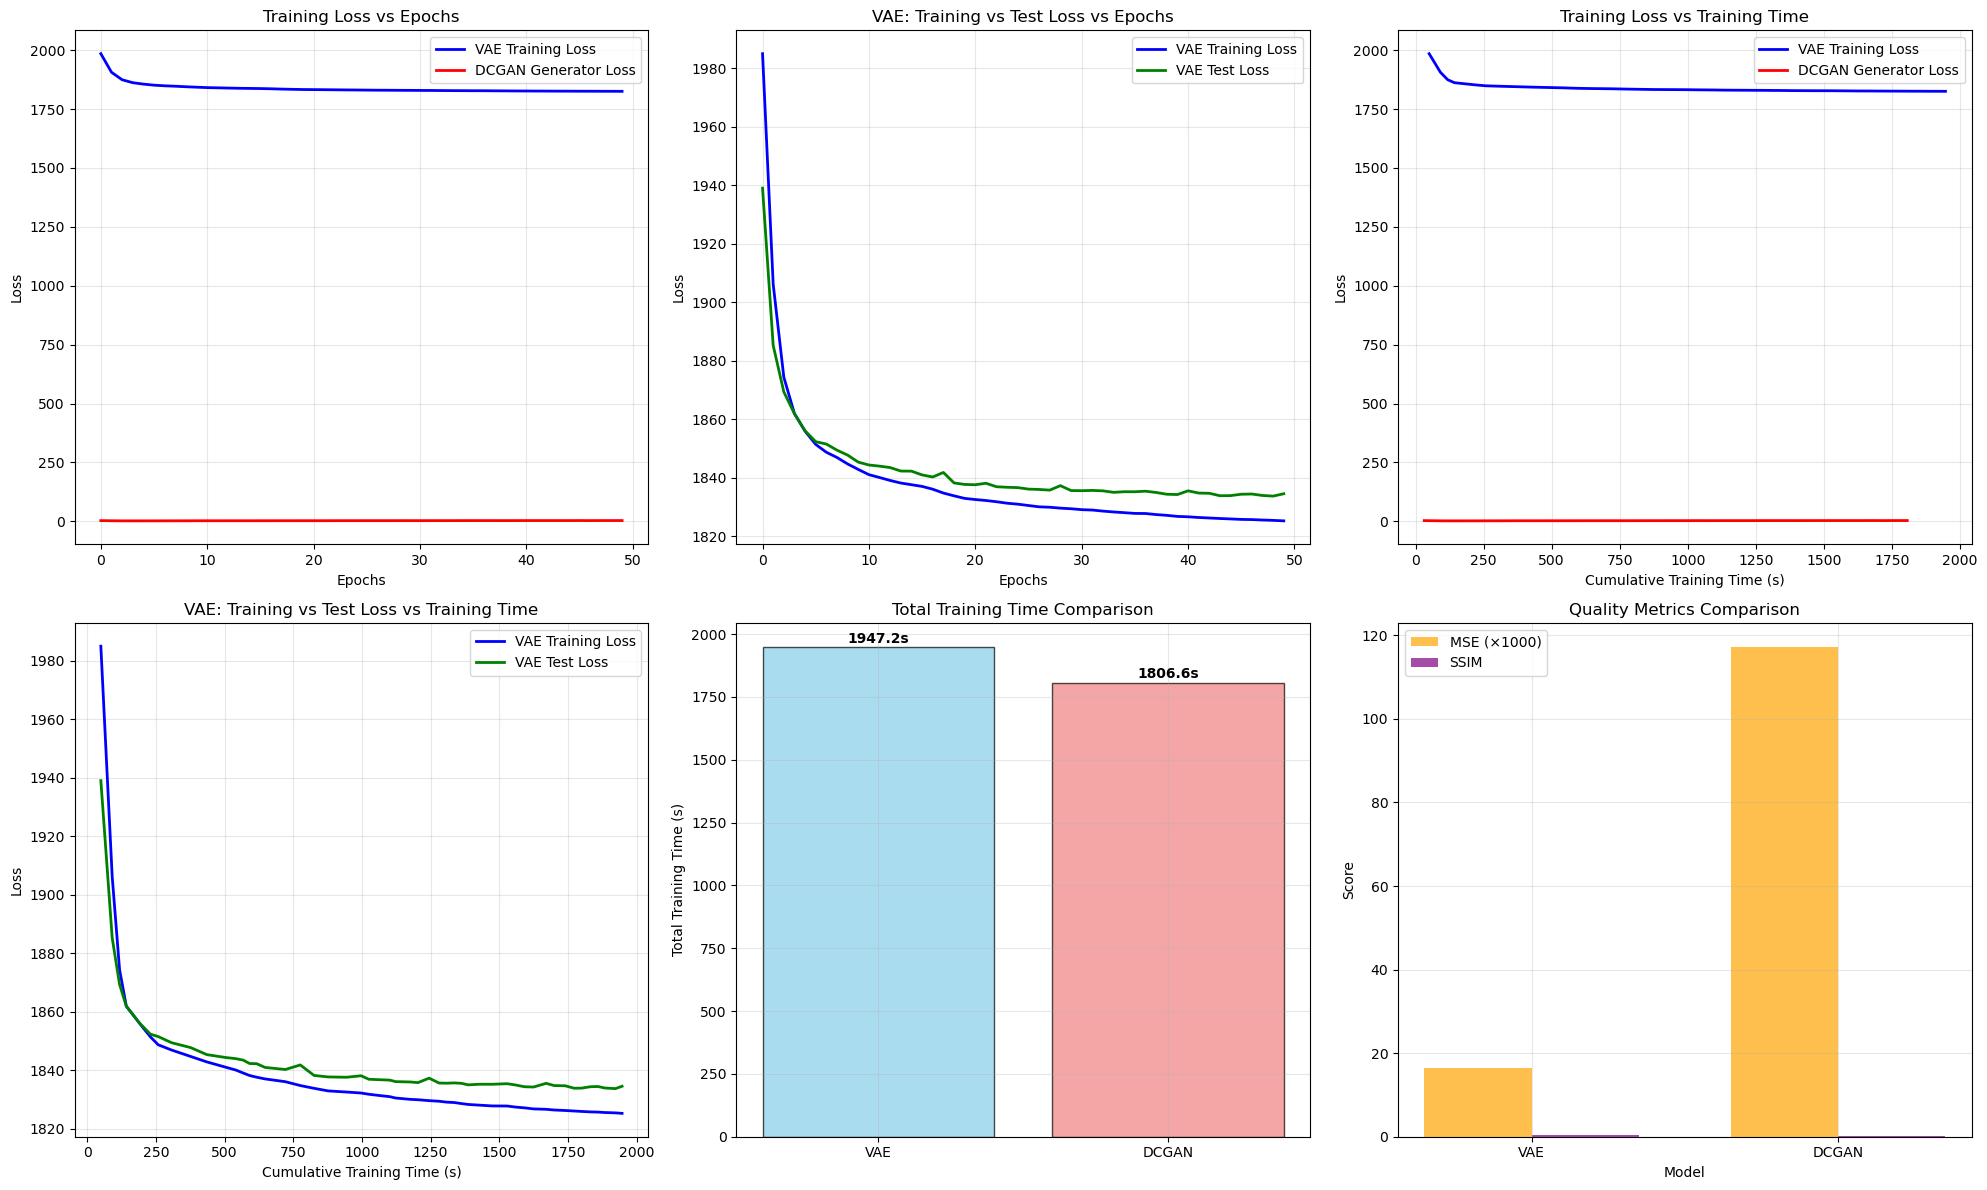

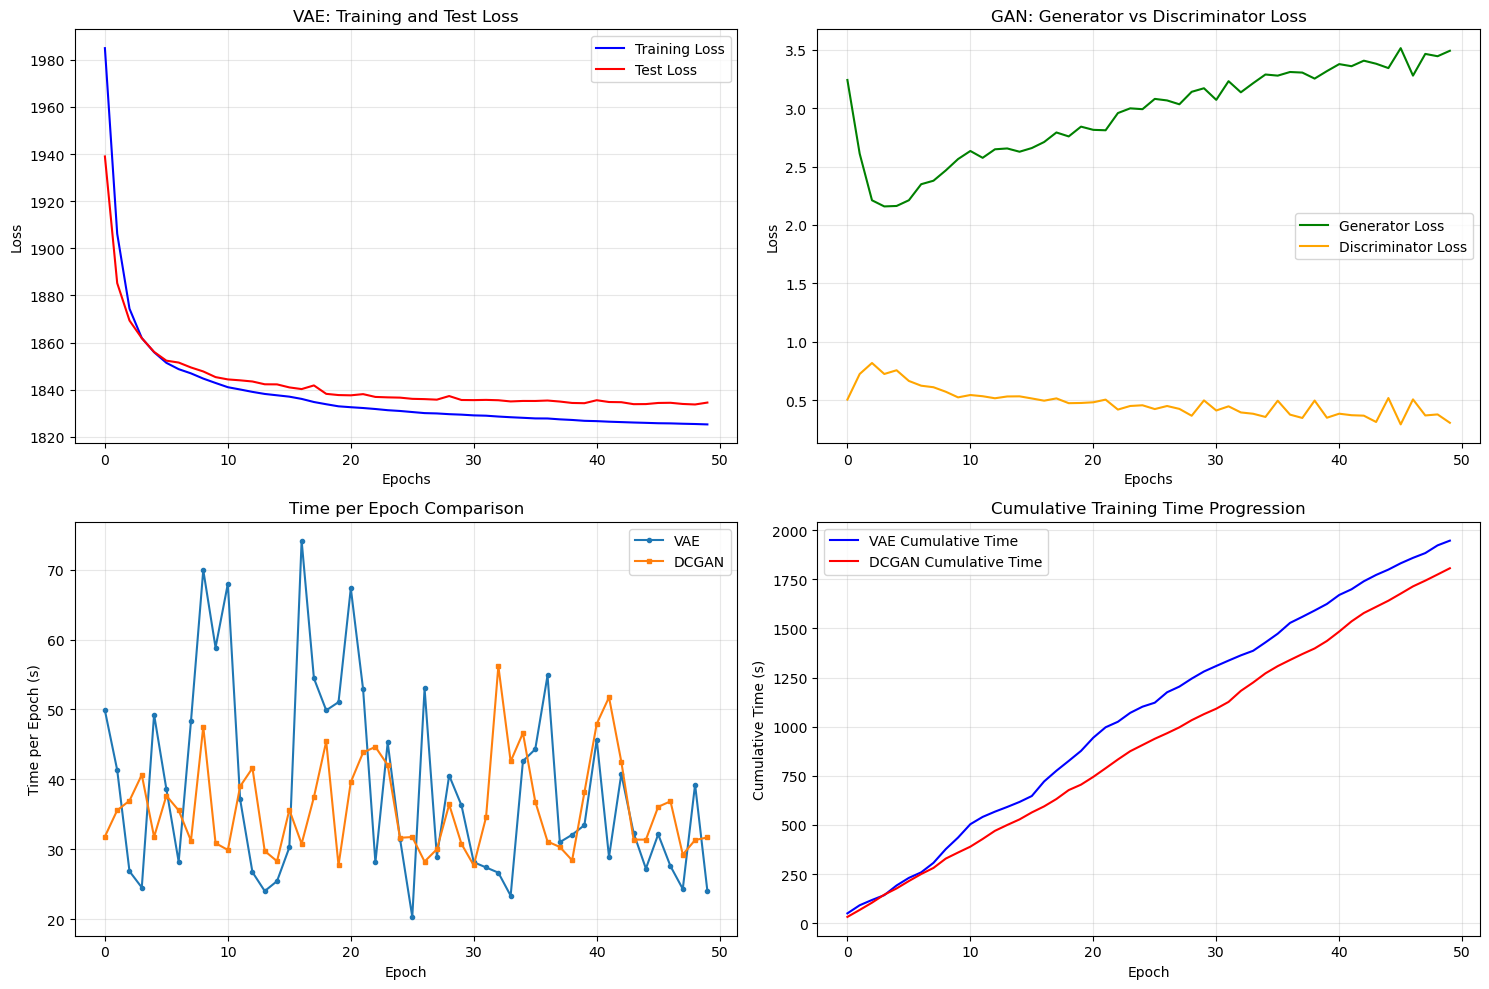


 All results saved in 'results_q3' directory.


In [36]:
# Enhanced Plotting
# ----------------------------
# Cumulative training time
vae_cum_time = np.cumsum(vae_epoch_times)
gan_cum_time = np.cumsum(gan_epoch_times)
    
# Create enhanced graphs as per requirements
plt.figure(figsize=(20, 12))

# Graph 1: Training loss vs epochs
plt.subplot(2, 3, 1)
plt.plot(vae_train_losses, label='VAE Training Loss', color='blue', linewidth=2)
plt.plot(gan_g_losses, label='DCGAN Generator Loss', color='red', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

# Graph 2: Training and testing loss vs epochs (VAE only)
plt.subplot(2, 3, 2)
plt.plot(vae_train_losses, label='VAE Training Loss', color='blue', linewidth=2)
plt.plot(vae_test_losses, label='VAE Test Loss', color='green', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE: Training vs Test Loss vs Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

# Graph 3: Training loss vs training time
plt.subplot(2, 3, 3)
plt.plot(vae_cum_time, vae_train_losses, label='VAE Training Loss', color='blue', linewidth=2)
plt.plot(gan_cum_time, gan_g_losses, label='DCGAN Generator Loss', color='red', linewidth=2)
plt.xlabel('Cumulative Training Time (s)')
plt.ylabel('Loss')
plt.title('Training Loss vs Training Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Graph 4: Training and testing loss vs training time (VAE)
plt.subplot(2, 3, 4)
plt.plot(vae_cum_time, vae_train_losses, label='VAE Training Loss', color='blue', linewidth=2)
plt.plot(vae_cum_time, vae_test_losses, label='VAE Test Loss', color='green', linewidth=2)
plt.xlabel('Cumulative Training Time (s)')
plt.ylabel('Loss')
plt.title('VAE: Training vs Test Loss vs Training Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Graph 5: Total training time comparison
plt.subplot(2, 3, 5)
models = ['VAE', 'DCGAN']
times = [vae_total_time, gan_total_time]
colors = ['skyblue', 'lightcoral']
bars = plt.bar(models, times, color=colors, edgecolor='black', alpha=0.7)
plt.ylabel('Total Training Time (s)')
plt.title('Total Training Time Comparison')
# Add value labels on bars
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3)

# Graph 6: MSE and SSIM comparison
plt.subplot(2, 3, 6)
x = np.arange(2)
width = 0.35

# Normalize MSE for better visualization (since MSE values are much smaller)
mse_values = [vae_mse * 1000, gan_mse * 1000]  # Scale for better visualization
ssim_values = [vae_ssim, gan_ssim]

plt.bar(x - width/2, mse_values, width, label='MSE (×1000)', color='orange', alpha=0.7)
plt.bar(x + width/2, ssim_values, width, label='SSIM', color='purple', alpha=0.7)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Quality Metrics Comparison')
plt.xticks(x, ['VAE', 'DCGAN'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'comprehensive_training_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Detailed VAE training analysis
ax1.plot(vae_train_losses, label='Training Loss', color='blue')
ax1.plot(vae_test_losses, label='Test Loss', color='red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('VAE: Training and Test Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# GAN training dynamics
ax2.plot(gan_g_losses, label='Generator Loss', color='green')
ax2.plot(gan_d_losses, label='Discriminator Loss', color='orange')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('GAN: Generator vs Discriminator Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Per-epoch time comparison
ax3.plot(vae_epoch_times, label='VAE', marker='o', markersize=3)
ax3.plot(gan_epoch_times, label='DCGAN', marker='s', markersize=3)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Time per Epoch (s)')
ax3.set_title('Time per Epoch Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Cumulative time progression
ax4.plot(vae_cum_time, label='VAE Cumulative Time', color='blue')
ax4.plot(gan_cum_time, label='DCGAN Cumulative Time', color='red')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Cumulative Time (s)')
ax4.set_title('Cumulative Training Time Progression')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'detailed_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n All results saved in '{results_dir}' directory.")